In [13]:
import pandas as pd
import requests
import json
import time
import gender_guesser.detector as gender
from babel import Locale
import pycountry_convert as pycc
from babel import Locale
sleep=0.4

In [3]:
LOCAL=False
if LOCAL:
    f=open('data/inspire_LA.json','r')
    df=json.load(f)
    f.close()
else:
    r=requests.get('https://github.com/restrepo/inspireauth/raw/main/data/inspire_LA.json')
    df=r.json()

In [4]:
print(len(df))

57588


## Extended papers data structure including `rank` and related information
1) Get ranks for each institution for authors with declared profile
2) Get ranks for each paper

### Extend data-scheme

In [6]:
from datetime import datetime
import copy
def get_country(institution_id,df):
    institution_id = str(institution_id)
    for d in df:
        country = None
        if d.get('institution_id') == institution_id:
            country = d.get('country')
            break
    return country
def flatten_list(L):
    return [item for sublist in L for item in sublist]

In [7]:
#Extend 'positions' data-scheme
i=0
for d in df:
    if d.get('positions'):
        for p in d.get('positions'):
            try:
                p['institution_id']=p.get('record').get('$ref').split('/')[-1]
            except:
                p['institution_id']=None
            if p.get('institution_id'):
                p['country']=get_country(p.get('institution_id'),df)
            else:
                p['country']=None
            p['author_id']=d.get('author_id')
    print(str(i).zfill(5),end='\r')
    i += 1                

#Extend 'papers' data-scheme
#d=df[4722]
i=0
for d in df:
    if d.get('positions'):
        dp=copy.deepcopy(d.get('positions'))
        for p in dp:
            try:
                p['institution_id'] = p.get('record').get('$ref').split('/')[-1]
            except:
                p['institution_id'] = None

    il = [p.get('institution_id') for p in dp]
    #papers = copy.deepcopy(d.get('papers'))
    papers = d.get('papers')
    for pr in papers:
        # Fix institution
        pr['institution_id'] = pr.pop('instituion_id')
        if pr.get('institution_id') in il:
            end_date=None
            ps=[p for p in dp if p.get('institution_id') == pr.get('institution_id')]
            for p in ps:
                if p.get('end_date'):
                    end_date=int(p.get('end_date').split('-')[0])
                else:
                    if p.get('current'):
                        end_date=datetime.now().year+1
                start_date=p.get('start_date')
                if start_date:
                    start_date=int(start_date.split('-')[0])
                try:
                    year=eval(pr.get('year'))
                except:
                    year=pr.get('year')
                if year:
                    year=int(year)
                if year and start_date and end_date and year in range(start_date,end_date+2): #+1 of tolerance
                    pr['rank'] = p.get('rank')
                    pr['start_date'] = p.get('start_date')
                    pr['end_date'] = p.get('end_date')
                    if p.get('current'):
                        pr['current'] = p.get('current')
                    pr['institution'] =p.get('institution')
                    pr['country'] = get_country(p.get('institution_id'),df)
        #if i==3:
        #    raise Exception(f'break -> {i}')
    print(str(i).zfill(5),end='\r')
    i += 1

### Find gender
__TODO__: check the language of the full name

In [8]:
gd = gender.Detector()

In [9]:
COUNTRIES={}
for c in gd.COUNTRIES:
    if c=='usa':
        CO='US'
    elif c=='east_frisia':
        CO='DE'
    elif c=='swiss':
        CO='CH'
    elif c=='bosniaand':
        CO='BA'
    elif c=='kosovo':
        CO='AL'
    elif c=='the_stans':
        CO='AF'
    elif c=='arabia':
        CO='SA'
    elif c=='korea':
        CO='KR'
    elif c=='other_countries':
        CO='oc'
    else:
        CO=pycc.country_name_to_country_alpha2( c.title().replace("_"," ").replace("The ",""))
    if CO != 'oc':
        COUNTRIES[Locale.parse(f'und_{CO}').language]=c
    else:
        COUNTRIES[CO] = c

In [10]:
def get_name(lasts_csv_names):
    try:
        name=(lasts_csv_names.split(', ')[-1]).split()[0] # Second name is usally a last name
    except:
        name='.'
    if name.find('.')!=-1:
        name=None
    return name

def get_main_language_country(country):
    co=pycc.country_name_to_country_alpha2(country)
    try:
        la=Locale.parse(f'und_{co}').language  # 'und' here means unknown language, co is country
    except:
        la='oc'
    try:
        COUNTRY=COUNTRIES.get(la)
    except:
        COUNTRY=COUNTRIES.get('oc')
    return COUNTRY

In [11]:
i=0
for d in df:
    try:
        name=get_name(d.get('name').get('value'))
    except:
        name=None
    if name is None:
        try:
            name = get_name(d.get('full_name'))
        except:
            pass
    country=d.get('country')
    if name and country:
        try:
            COUNTRY=get_main_language_country(country)
        except:
            COUNTRY=get_main_language_country(country.split()[0])
        gender=gd.get_gender(name,COUNTRY)
    else:
        gender=None
    d['gender'] = gender
    print(str(i).zfill(5),end='\r')
    i += 1    

### Rank of the author analysis
Rank(s) obtained by the author in the country

In [177]:
profile_ranks = [d.get('positions') for d in df if d.get('positions') and 
                        any([True for dd in d.get('positions') if dd.get('rank')])]
profile_ranks = flatten_list(profile_ranks)
profile_ranks = [p for p in profile_ranks if p.get('rank')]

In [194]:
dfp=pd.DataFrame(profile_ranks).drop_duplicates(subset=[
     'rank','end_date','start_date','institution','curated_relation','institution_id','country','author_id','current','hidden'
    ]).reset_index(drop=True)
dfp['rank'].value_counts()

POSTDOC          6455
PHD              6241
SENIOR           3490
UNDERGRADUATE    3128
JUNIOR           1491
MASTER           1351
VISITOR           708
STAFF             548
OTHER              20
Name: rank, dtype: int64

In [224]:
len(df)

57588

In [226]:
dfp.shape,dfp['rank'].value_counts().sum()

((29816, 13), 29816)

In [195]:
dfp['rank'].unique()

array(['PHD', 'SENIOR', 'POSTDOC', 'MASTER', 'UNDERGRADUATE', 'JUNIOR',
       'VISITOR', 'STAFF', 'OTHER'], dtype=object)

In [196]:
dfp[dfp['country']=='Chile']['rank'].value_counts()

POSTDOC          110
PHD              108
UNDERGRADUATE     77
SENIOR            65
MASTER            46
JUNIOR            44
VISITOR           11
STAFF              4
OTHER              3
Name: rank, dtype: int64

Explanation: 
* 110 authors work as POSTDOC in Chile, etc.
* 108 authors did their PHD in Chile, etc.

In [197]:
tmp=dfp[dfp['country']=='Chile']
tmp[ (tmp['rank']=='STAFF') ]

,rank,record,end_date,start_date,institution,curated_relation,institution_id,country,author_id,current,hidden
2973,STAFF,{'$ref': 'https://inspirehep.net/api/instituti...,NaN,2016,"Chile Austral U., Valdivia",True,903797,Chile,P.Mella.2,True,NaN
7681,STAFF,{'$ref': 'https://inspirehep.net/api/instituti...,NaN,2019,"San Sebastian U., Chile",True,1459222,Chile,M.Riquelme.1,True,NaN
23270,STAFF,{'$ref': 'https://inspirehep.net/api/instituti...,2019,2016,Concepcion U.,True,904435,Chile,F.I.Portales.Oliva.1,False,False
23271,STAFF,{'$ref': 'https://inspirehep.net/api/instituti...,2019,2016,"San Sebastian U., Chile",True,1459222,Chile,F.I.Portales.Oliva.1,False,False


In [198]:
dfp[dfp['country']=='Brazil']['rank'].value_counts()

PHD              445
POSTDOC          345
UNDERGRADUATE    254
MASTER           239
SENIOR           232
JUNIOR            65
VISITOR           51
STAFF             46
Name: rank, dtype: int64

In [199]:
dfp[dfp['country']=='Argentina']['rank'].value_counts()

PHD              136
UNDERGRADUATE     88
SENIOR            42
POSTDOC           41
MASTER            27
JUNIOR            16
STAFF             13
VISITOR            3
Name: rank, dtype: int64

In [200]:
dfp[dfp['country']=='Mexico']['rank'].value_counts()

PHD              185
POSTDOC          124
SENIOR            87
UNDERGRADUATE     85
MASTER            71
JUNIOR            59
STAFF             26
VISITOR           10
OTHER              1
Name: rank, dtype: int64

In [201]:
dfp[dfp['country']=='Colombia']['rank'].value_counts()

UNDERGRADUATE    48
SENIOR           32
MASTER           21
JUNIOR           19
PHD              15
POSTDOC          15
STAFF             5
VISITOR           1
Name: rank, dtype: int64

In [202]:
dfp[dfp['country']=='Uruguay']['rank'].value_counts()

UNDERGRADUATE    5
MASTER           3
PHD              2
STAFF            2
POSTDOC          1
SENIOR           1
JUNIOR           1
Name: rank, dtype: int64

In [203]:
dfp[dfp['country']=='Uruguay']

,rank,record,end_date,start_date,institution,curated_relation,institution_id,country,author_id,current,hidden
543,MASTER,{'$ref': 'https://inspirehep.net/api/instituti...,2003,NaN,"Republica U., Montevideo",True,903022,Uruguay,R.A.Porto.1,NaN,NaN
845,POSTDOC,{'$ref': 'https://inspirehep.net/api/instituti...,2014,2012,"Republica U., Montevideo",True,903022,Uruguay,J.Olmedo.1,NaN,NaN
857,PHD,{'$ref': 'https://inspirehep.net/api/instituti...,2012,2007,"Republica U., Montevideo",True,903022,Uruguay,S.Rastgoo.1,False,False
896,STAFF,{'$ref': 'https://inspirehep.net/api/instituti...,NaN,NaN,"Republica U., Montevideo",True,903022,Uruguay,G.A.Gonzalez.Sprinberg.1,True,NaN
1347,MASTER,{'$ref': 'https://inspirehep.net/api/instituti...,2012,2009,"Republica U., Montevideo",True,903022,Uruguay,L.Duarte.1,NaN,NaN
1348,UNDERGRADUATE,{'$ref': 'https://inspirehep.net/api/instituti...,2008,2002,"Republica U., Montevideo",True,903022,Uruguay,L.Duarte.1,NaN,NaN
1415,SENIOR,{'$ref': 'https://inspirehep.net/api/instituti...,NaN,2008,"Republica U., Montevideo",True,903022,Uruguay,R.Donangelo.1,NaN,NaN
1417,PHD,{'$ref': 'https://inspirehep.net/api/instituti...,2003,NaN,"Republica U., Montevideo",True,903022,Uruguay,Pablo.Mora.1,NaN,NaN
1433,MASTER,{'$ref': 'https://inspirehep.net/api/instituti...,NaN,NaN,"Republica U., Montevideo",True,903022,Uruguay,M.Ponce.1,NaN,NaN
1434,UNDERGRADUATE,{'$ref': 'https://inspirehep.net/api/instituti...,NaN,NaN,"Republica U., Montevideo",True,903022,Uruguay,M.Ponce.1,NaN,NaN


### Gender analysis
The higher ranks are less probable for women

In [163]:
pd.DataFrame(df)[50:60][['profile_id','author_id','full_name','name','country','gender']]

,profile_id,author_id,full_name,name,country,gender
50,None,J.Chela.Flores.1,"Chela-Flores, J.",None,Italy,None
51,2074632,R.Paredes.1,"Paredes, R.",None,Venezuela,None
52,1019827,C.Aragone.1,"Aragone, C.","{'value': 'Aragone, Carlos', 'preferred_name':...",Venezuela,male
53,2455877,G.Colagiacomo.1,"Colagiacomo, G.",None,Venezuela,None
54,1008438,R.Gianvittorio.1,"Gianvittorio, R.","{'value': 'Gianvittorio, Rita', 'preferred_nam...",Venezuela,female
55,1000877,L.Leal.1,"Leal, L.","{'value': 'Leal, Lorenzo', 'preferred_name': '...",Venezuela,male
56,1008978,R.Gambini.1,"Gambini, Rodolfo","{'value': 'Gambini, Rodolfo', 'preferred_name'...",Uruguay,male
57,1050545,A.Trias.1,"Trias, Antoni","{'value': 'Trias, Antoni', 'preferred_name': '...",Spain,male
58,2222068,E.Mac.2,"Mac, E.",None,Venezuela,None
59,985291,E.Ugaz.1,"Ugaz, E.","{'value': 'Ugaz, Eduardo', 'preferred_name': '...",Peru,male


In [205]:
dff=[d for d in df if d.get('gender')=='female']
dfm=[d for d in df if d.get('gender')=='male']

In [206]:
len(dff)

2742

In [207]:
profile_ranks = [d.get('positions') for d in dfm if d.get('positions') and 
                        any([True for dd in d.get('positions') if dd.get('rank')])]
profile_ranks = flatten_list(profile_ranks)
profile_ranks = [p for p in profile_ranks if p.get('rank')]

dfp=pd.DataFrame(profile_ranks).drop_duplicates(subset=[
     'rank','end_date','start_date','institution','curated_relation','institution_id','country','author_id','current','hidden'
    ]).reset_index(drop=True)
dfp['rank'].value_counts()

POSTDOC          3204
PHD              3147
SENIOR           2004
UNDERGRADUATE    1698
JUNIOR            729
MASTER            631
VISITOR           358
STAFF             308
OTHER              10
Name: rank, dtype: int64

In [208]:
dfp[dfp['country']=='Brazil']['rank'].value_counts()

PHD              181
POSTDOC          147
UNDERGRADUATE    125
SENIOR           116
MASTER           109
JUNIOR            29
STAFF             25
VISITOR           21
Name: rank, dtype: int64

In [209]:
dfp[dfp['country']=='Colombia']['rank'].value_counts()

UNDERGRADUATE    32
SENIOR           26
JUNIOR           15
MASTER           14
PHD              13
POSTDOC          10
STAFF             4
VISITOR           1
Name: rank, dtype: int64

In [210]:
profile_ranks = [d.get('positions') for d in dff if d.get('positions') and 
                        any([True for dd in d.get('positions') if dd.get('rank')])]
profile_ranks = flatten_list(profile_ranks)
profile_ranks = [p for p in profile_ranks if p.get('rank')]

dfp=pd.DataFrame(profile_ranks).drop_duplicates(subset=[
     'rank','end_date','start_date','institution','curated_relation','institution_id','country','author_id','current','hidden'
    ]).reset_index(drop=True)
dfp['rank'].value_counts()

POSTDOC          439
PHD              400
SENIOR           187
UNDERGRADUATE    179
JUNIOR            98
MASTER            69
STAFF             44
VISITOR           34
Name: rank, dtype: int64

In [211]:
dfp[dfp['country']=='Brazil']['rank'].value_counts()

POSTDOC          27
PHD              24
UNDERGRADUATE    13
MASTER           11
SENIOR           10
VISITOR           3
STAFF             2
JUNIOR            2
Name: rank, dtype: int64

In [212]:
dfp[dfp['country']=='Colombia']['rank'].value_counts()

SENIOR    2
MASTER    1
Name: rank, dtype: int64

In [213]:
dfp[dfp['country']=='Colombia']

,rank,record,end_date,institution,curated_relation,institution_id,country,author_id,current,start_date,hidden
94,SENIOR,{'$ref': 'https://inspirehep.net/api/instituti...,2019,Antonio Narino U.,True,908168,Colombia,M.Losada.1,NaN,1999,NaN
162,MASTER,{'$ref': 'https://inspirehep.net/api/instituti...,2012,"Colombia, U. Natl.",True,906485,Colombia,Erika.Catano.Mur.1,NaN,NaN,NaN
715,SENIOR,{'$ref': 'https://inspirehep.net/api/instituti...,NaN,Antonio Narino U.,True,908168,Colombia,G.A.Navarro.1,True,2007,NaN


### Rank paper analysis
Rank of the authors of each paper. A paper can have a rank for each author in the best case scenario

In [214]:
papers_ranks = [d.get('papers') for d in df if d.get('papers') and 
                        any([True for dd in d.get('papers') if dd.get('rank')])]
papers_ranks = flatten_list(papers_ranks)
papers_ranks = [p for p in papers_ranks if p.get('rank')]

In [215]:
dfp=pd.DataFrame(papers_ranks)
dfp=dfp.drop_duplicates(subset=[
     'recid','year','citation_count','journal_id','author_id','institution_id','rank','start_date','end_date','institution','country','current'
    ]).reset_index(drop=True)

In [216]:
dfp['rank'].value_counts()

SENIOR           14313
POSTDOC           5418
PHD               4154
JUNIOR            2631
STAFF             1733
MASTER             705
VISITOR            648
UNDERGRADUATE      206
OTHER                8
Name: rank, dtype: int64

In [34]:
dfp[dfp['country']=='Brazil']['rank'].value_counts()

SENIOR           5339
PHD              1721
POSTDOC          1362
STAFF             675
JUNIOR            593
MASTER            405
VISITOR           309
UNDERGRADUATE      66
Name: rank, dtype: int64

Explanation: 5339 papers have a SENIOR author from Brazil at the moment of the publication

In [35]:
dfp[dfp['country']=='Chile']['rank'].value_counts()

SENIOR           923
POSTDOC          772
JUNIOR           441
PHD              323
MASTER            87
VISITOR           34
UNDERGRADUATE     19
OTHER              4
STAFF              1
Name: rank, dtype: int64

In [36]:
dfp[dfp['country']=='Argentina']['rank'].value_counts()

SENIOR           726
PHD              422
JUNIOR           135
STAFF            120
POSTDOC          101
UNDERGRADUATE     34
MASTER            14
Name: rank, dtype: int64

In [219]:
dfp[dfp['country']=='Colombia']['rank'].value_counts()

SENIOR           505
JUNIOR           110
POSTDOC           60
PHD               38
MASTER            27
UNDERGRADUATE     26
VISITOR           13
STAFF              9
Name: rank, dtype: int64

Explanation: 38 papers have a PHD author from Colombia at the moment of the publication

In [222]:
tmp=dfp[dfp['country']=='Colombia']
tmp[tmp['rank']=='PHD']

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,institution_id,rank,start_date,end_date,institution,country,current
4645,853376,2010,6,[astro-ph.CO],None,C.A.Valenzuela.Toledo.1,907675,PHD,2007,2010,Santander Industrial U.,Colombia,NaN
4646,817333,2010,56,[hep-ph],1212538,C.A.Valenzuela.Toledo.1,907675,PHD,2007,2010,Santander Industrial U.,Colombia,NaN
4648,834841,2010,61,[astro-ph.CO],None,C.A.Valenzuela.Toledo.1,907675,PHD,2007,2010,Santander Industrial U.,Colombia,NaN
4649,803498,2010,72,[astro-ph],None,C.A.Valenzuela.Toledo.1,907675,PHD,2007,2010,Santander Industrial U.,Colombia,NaN
4650,831907,2009,59,[astro-ph.CO],None,C.A.Valenzuela.Toledo.1,907675,PHD,2007,2010,Santander Industrial U.,Colombia,NaN
7428,1627633,2018,21,[hep-ph],None,G.Palacio.1,903906,PHD,2013,2017,Antioquia U.,Colombia,NaN
7429,1484690,2016,5,[hep-ph],None,G.Palacio.1,903906,PHD,2013,2017,Antioquia U.,Colombia,NaN
7430,1455793,2016,24,[hep-ph],None,G.Palacio.1,903906,PHD,2013,2017,Antioquia U.,Colombia,NaN
7622,1365306,2015,63,[hep-ph],None,A.Rivera.1,903906,PHD,2014,2017,Antioquia U.,Colombia,NaN
7624,1421624,2016,33,[hep-ph],1212538,A.Rivera.1,903906,PHD,2014,2017,Antioquia U.,Colombia,NaN


### Rank author-papers analysis

In [8]:
profile_ranks = [d.get('positions') for d in df if d.get('positions') and 
                        any([True for dd in d.get('positions') if dd.get('rank')])]
profile_ranks = flatten_list(profile_ranks)
profile_ranks = [p for p in profile_ranks if p.get('rank')]
dfp=pd.DataFrame(profile_ranks)

In [9]:
papers_ranks = [d.get('papers') for d in df if d.get('papers') and 
                        any([True for dd in d.get('papers') if isinstance(dd.get('rank'),str)])]
papers_ranks = flatten_list(papers_ranks)
papers_ranks = [p for p in papers_ranks if p.get('rank')]

In [10]:
dfpp=pd.DataFrame(papers_ranks)
dfpp=dfpp.drop_duplicates(subset=[
     'recid','year','citation_count','journal_id','author_id','institution_id','rank','start_date','end_date','institution','country','current'
    ]).reset_index(drop=True)

In [11]:
def get_region(c,country='Colombia',LA_countries=['Brazil', 'Mexico', 'Argentina','Chile', 'Colombia','Bolivia','Cuba', #5
              'Costa Rica', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras', #10
               'Nicaragua', 'Panama', 'Paraguay', 'Peru', #15
              'Dominican Republic','Uruguay','Venezuela']):
    if c in LA_countries:
        region='LA'
    else:
        region='WW'
    if c==country:
        region=pycc.country_name_to_country_alpha2(country)
    return region

In [14]:
country='Colombia'
dfc=dfp[dfp['country']==country]
au=dfc['author_id'].unique()
dfppc=dfpp[dfpp['author_id'].apply(lambda a: a in au)].drop_duplicates(subset=['institution_id','rank','start_date','end_date']).reset_index(drop=True)

dfppc['region']=dfppc['country'].apply(lambda c:get_region(c,country=country ))

In [15]:
dfppc

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,institution_id,rank,start_date,end_date,institution,country,current,region
0,287309,1990,2,[],1214843,L.A.Nunez.1,905162,SENIOR,1979,2009,"Andes U., Merida",Venezuela,NaN,LA
1,1826656,2020,7,[astro-ph.IM],None,L.A.Nunez.1,907675,SENIOR,2010,None,Santander Industrial U.,Colombia,True,CO
2,710343,2006,27,[gr-qc],1214779,G.A.Gonzalez.1,907675,SENIOR,1990,None,Santander Industrial U.,Colombia,True,CO
3,1791901,2020,7,[physics.ins-det],1212215,H.Asorey.1,902724,SENIOR,2010,None,Centro Atomico Bariloche,Argentina,True,LA
4,1357122,2015,2,[astro-ph.IM],1365972,H.Asorey.1,907675,VISITOR,2013,None,Santander Industrial U.,Colombia,True,CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,686372,2005,2,[hep-ph],1213302,G.A.Navarro.1,902701,PHD,2002,2007,Buenos Aires U.,Argentina,NaN,LA
155,1375843,2015,12,[hep-th],1214855,D.Cogollo.1,909535,SENIOR,2009,None,Campina Grande Federal U.,Brazil,True,LA
156,788685,2008,36,[hep-ph],None,D.Cogollo.1,903793,PHD,2005,2009,Paraiba U.,Brazil,NaN,LA
157,1797273,2020,13,[gr-qc],1214779,C.Posada.1,907680,POSTDOC,2019,None,"Silesian U., Czech Republic",Czechia,True,WW


In [16]:
dfppc['region'].value_counts()

CO    76
LA    44
WW    39
Name: region, dtype: int64

Explanation of next result for PHD: 
* 8 authors who have some rank from Colombia, published as PHD students from Colombia, 
* 21 authors who have some rank from Colombia, published as PHD students from the rest of the Latin America,
* 9 authors who have some rank from Colombia, published as PHD students from the rest of the world wide.

In [17]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [18]:
def get_bottom(L):
    xtot=0
    bottom=[]
    for x in L:
        bottom.append(xtot)
        xtot=xtot+x
    return bottom

def get_colors(indexes):
    return [colors.get(x) for x in indexes ]

CO    5
Name: region, dtype: int64
CO     8
LA    21
WW     9
Name: region, dtype: int64
CO    10
LA     8
WW    20
Name: region, dtype: int64
CO    17
LA     1
WW     1
Name: region, dtype: int64
CO    23
LA     3
WW     2
Name: region, dtype: int64


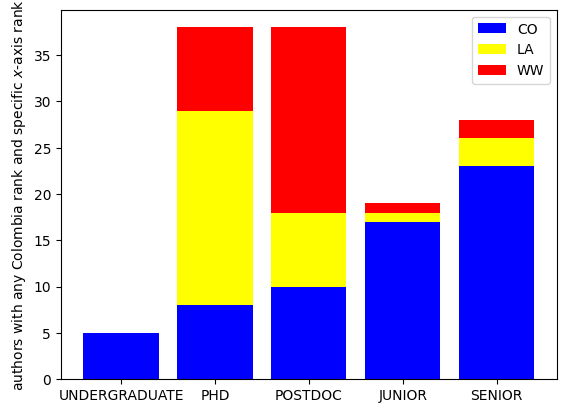

In [19]:
CO=pycc.country_name_to_country_alpha2(country)
colors = {f'{CO}':'b','LA':'yellow','WW':'r'}

ranks=['UNDERGRADUATE','PHD','POSTDOC','JUNIOR','SENIOR']
x=0
rank=ranks[x]

vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc),label=vc.keys())

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

plt.xticks(range(5),ranks)
plt.ylabel( f'authors with any {country} rank and specific $x$-axis rank' )

plt.legend()

In [474]:
dfppc[dfppc['rank']=='UNDERGRADUATE']['region'].value_counts().sort_index()

CO    5
Name: region, dtype: int64

The 8 authors who have some rank from Colombia, have published as PHD students from Colombia:

In [387]:
dfppc[ (dfppc['rank']=='PHD') & (dfppc['region']=='CO') ]

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,institution_id,rank,start_date,end_date,institution,country,current,region
23,853376,2010,6,[astro-ph.CO],None,C.A.Valenzuela.Toledo.1,907675,PHD,2007,2010,Santander Industrial U.,Colombia,NaN,CO
70,1627633,2018,21,[hep-ph],None,G.Palacio.1,903906,PHD,2013,2017,Antioquia U.,Colombia,NaN,CO
81,1365306,2015,63,[hep-ph],None,A.Rivera.1,903906,PHD,2014,2017,Antioquia U.,Colombia,NaN,CO
85,1846554,2021,8,[hep-ph],None,J.Calle.1,903906,PHD,2018,2021,Antioquia U.,Colombia,True,CO
105,800124,2009,204,[gr-qc],None,A.Oliveros.1,907194,PHD,2006,2009,"Valle U., Cali",Colombia,NaN,CO
117,1351928,2015,46,[hep-ph],1213103,C.Salazar.3,903906,PHD,2014,None,Antioquia U.,Colombia,True,CO
136,1088190,2012,0,[],None,A.Andres.Ocampo.Rios.1,903802,PHD,2007,2011,"Andes U., Bogota",Colombia,NaN,CO
146,1346496,2016,5,[gr-qc],None,S.A.Vallejo.1,903906,PHD,2016,2020,Antioquia U.,Colombia,True,CO


In [499]:
country='Brazil'
dfc=dfp[dfp['country']==country]
au=dfc['author_id'].unique()
dfppc=dfpp[dfpp['author_id'].apply(lambda a: a in au)].drop_duplicates(subset=['institution_id','rank','start_date','end_date']).reset_index(drop=True)

dfppc['region']=dfppc['country'].apply(lambda c:get_region(c,country=country ))

BR    24
LA     2
Name: region, dtype: int64
BR    227
LA      9
WW     49
Name: region, dtype: int64
BR    223
LA     12
WW    167
Name: region, dtype: int64
BR    50
LA    11
WW    18
Name: region, dtype: int64
BR    154
LA     16
WW     32
Name: region, dtype: int64


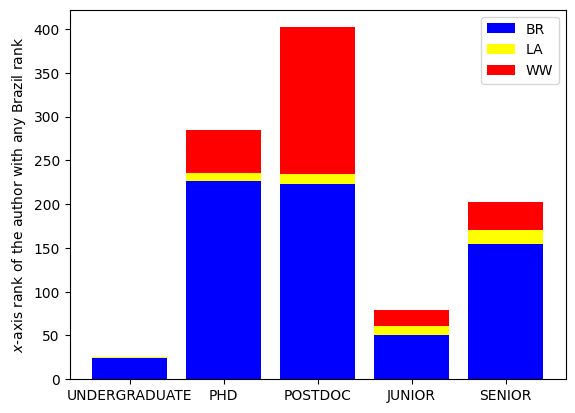

In [500]:
CO=pycc.country_name_to_country_alpha2(country)
colors[CO]='b'

ranks=['UNDERGRADUATE','PHD','POSTDOC','JUNIOR','SENIOR']
x=0
rank=ranks[x]

vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc),label=vc.keys())

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

plt.xticks(range(5),ranks)
plt.ylabel( f'$x$-axis rank of the author with any {country} rank' )

plt.legend()

In [497]:
country='Chile'
dfc=dfp[dfp['country']==country]
au=dfc['author_id'].unique()
dfppc=dfpp[dfpp['author_id'].apply(lambda a: a in au)].drop_duplicates(subset=['institution_id','rank','start_date','end_date']).reset_index(drop=True)

dfppc['region']=dfppc['country'].apply(lambda c:get_region(c,country=country ))

CL    10
LA     6
Name: region, dtype: int64
CL    64
LA    14
WW    35
Name: region, dtype: int64
CL    80
LA    18
WW    46
Name: region, dtype: int64
CL    40
LA     5
WW    14
Name: region, dtype: int64
CL    41
LA     8
WW     7
Name: region, dtype: int64


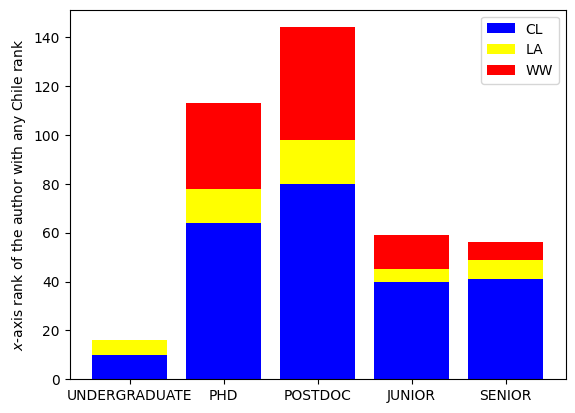

In [498]:
CO=pycc.country_name_to_country_alpha2(country)
colors[CO]='b'

ranks=['UNDERGRADUATE','PHD','POSTDOC','JUNIOR','SENIOR']
x=0
rank=ranks[x]

vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc),label=vc.keys())

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

plt.xticks(range(5),ranks)
plt.ylabel( f'$x$-axis rank of the author with any {country} rank' )

plt.legend()

### Any Colombian paper

In [20]:
dfp=pd.DataFrame(df)

CO    7
Name: region, dtype: int64
CO     8
LA    19
WW    12
Name: region, dtype: int64
CO    10
LA    11
WW    28
Name: region, dtype: int64
CO    17
LA     2
WW     1
Name: region, dtype: int64
CO    23
LA    10
WW     4
Name: region, dtype: int64


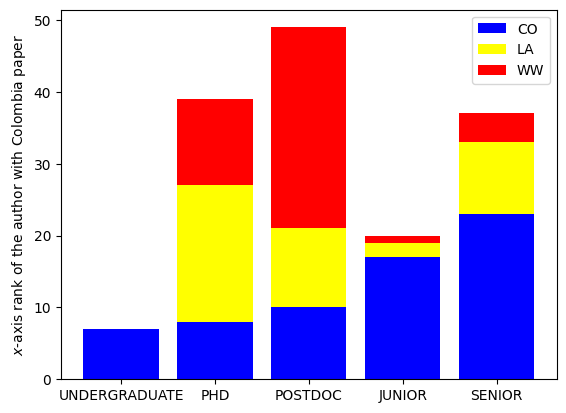

In [44]:
country='Colombia'

papers_ranks = [d.get('papers') for d in df if d.get('papers') and 
                        any([True for dd in d.get('papers') if isinstance(dd.get('rank'),str)])]
papers_ranks = flatten_list(papers_ranks)
papers_ranks = [p for p in papers_ranks if p.get('rank')]

dfpp=pd.DataFrame(papers_ranks)
dfpp=dfpp.drop_duplicates(subset=[
     'recid','year','citation_count','journal_id','author_id','institution_id','rank','start_date','end_date','institution','country','current'
    ]).reset_index(drop=True)

dfc=dfp[dfp['country']==country]
au=dfc['author_id'].unique()
dfppc=dfpp[dfpp['author_id'].apply(lambda a: a in au)].drop_duplicates(subset=['institution_id','rank','start_date','end_date']).reset_index(drop=True)

dfppc['region']=dfppc['country'].apply(lambda c:get_region(c,country=country ))

CO=pycc.country_name_to_country_alpha2(country)
colors[CO]='b'

ranks=['UNDERGRADUATE','PHD','POSTDOC','JUNIOR','SENIOR']
x=0
rank=ranks[x]

vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc),label=vc.keys())

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

plt.xticks(range(5),ranks)
plt.ylabel( f'$x$-axis rank of the author with {country} paper' )

plt.legend()

We can identify visitors as JUNIOR/SENIOR in an institution (country) in papers with affiliations to other institutions (countries)

BR    32
LA     6
Name: region, dtype: int64
BR    230
LA     15
WW     65
Name: region, dtype: int64
BR    229
LA     18
WW    209
Name: region, dtype: int64
BR    50
LA    12
WW    30
Name: region, dtype: int64
BR    155
LA     30
WW    105
Name: region, dtype: int64


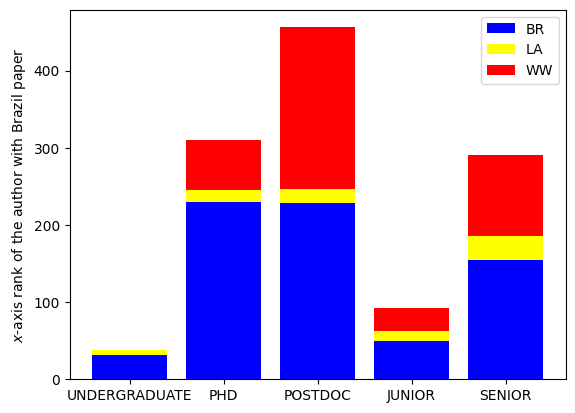

In [45]:
country='Brazil'

papers_ranks = [d.get('papers') for d in df if d.get('papers') and 
                        any([True for dd in d.get('papers') if isinstance(dd.get('rank'),str)])]
papers_ranks = flatten_list(papers_ranks)
papers_ranks = [p for p in papers_ranks if p.get('rank')]

dfpp=pd.DataFrame(papers_ranks)
dfpp=dfpp.drop_duplicates(subset=[
     'recid','year','citation_count','journal_id','author_id','institution_id','rank','start_date','end_date','institution','country','current'
    ]).reset_index(drop=True)

dfc=dfp[dfp['country']==country]
au=dfc['author_id'].unique()
dfppc=dfpp[dfpp['author_id'].apply(lambda a: a in au)].drop_duplicates(subset=['institution_id','rank','start_date','end_date']).reset_index(drop=True)

dfppc['region']=dfppc['country'].apply(lambda c:get_region(c,country=country ))

CO=pycc.country_name_to_country_alpha2(country)
colors[CO]='b'

ranks=['UNDERGRADUATE','PHD','POSTDOC','JUNIOR','SENIOR']
x=0
rank=ranks[x]

vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc),label=vc.keys())

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

plt.xticks(range(5),ranks)
plt.ylabel( f'$x$-axis rank of the author with {country} paper' )

plt.legend()

CL    11
LA     8
WW     1
Name: region, dtype: int64
CL    64
LA    23
WW    43
Name: region, dtype: int64
CL    81
LA    24
WW    78
Name: region, dtype: int64
CL    40
LA     8
WW    20
Name: region, dtype: int64
CL    41
LA    20
WW    42
Name: region, dtype: int64


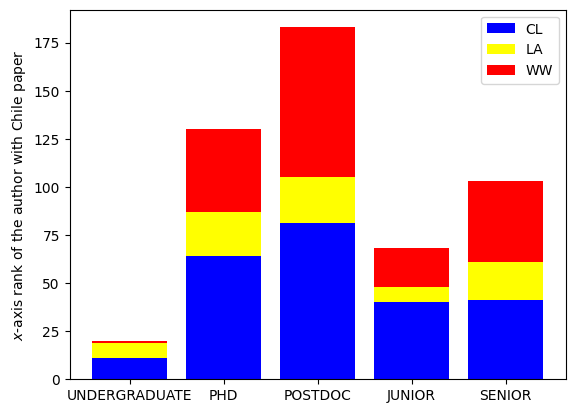

In [46]:
country='Chile'

papers_ranks = [d.get('papers') for d in df if d.get('papers') and 
                        any([True for dd in d.get('papers') if isinstance(dd.get('rank'),str)])]
papers_ranks = flatten_list(papers_ranks)
papers_ranks = [p for p in papers_ranks if p.get('rank')]

dfpp=pd.DataFrame(papers_ranks)
dfpp=dfpp.drop_duplicates(subset=[
     'recid','year','citation_count','journal_id','author_id','institution_id','rank','start_date','end_date','institution','country','current'
    ]).reset_index(drop=True)

dfc=dfp[dfp['country']==country]
au=dfc['author_id'].unique()
dfppc=dfpp[dfpp['author_id'].apply(lambda a: a in au)].drop_duplicates(subset=['institution_id','rank','start_date','end_date']).reset_index(drop=True)

dfppc['region']=dfppc['country'].apply(lambda c:get_region(c,country=country ))

CO=pycc.country_name_to_country_alpha2(country)
colors[CO]='b'

ranks=['UNDERGRADUATE','PHD','POSTDOC','JUNIOR','SENIOR']
x=0
rank=ranks[x]

vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc),label=vc.keys())

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

plt.xticks(range(5),ranks)
plt.ylabel( f'$x$-axis rank of the author with {country} paper' )

plt.legend()

In [ ]:
country='Guatemala'

papers_ranks = [d.get('papers') for d in df if d.get('papers') and 
                        any([True for dd in d.get('papers') if isinstance(dd.get('rank'),str)])]
papers_ranks = flatten_list(papers_ranks)
papers_ranks = [p for p in papers_ranks if p.get('rank')]

dfpp=pd.DataFrame(papers_ranks)
dfpp=dfpp.drop_duplicates(subset=[
     'recid','year','citation_count','journal_id','author_id','institution_id','rank','start_date','end_date','institution','country','current'
    ]).reset_index(drop=True)


au=dfp['author_id'].unique()
dfppc=dfpp[dfpp['author_id'].apply(lambda a: a in au)].drop_duplicates(subset=['institution_id','rank','start_date','end_date']).reset_index(drop=True)

dfppc['region']=dfppc['country'].apply(lambda c:get_region(c,country=country ))

CO=pycc.country_name_to_country_alpha2(country)
colors[CO]='b'

ranks=['UNDERGRADUATE','PHD','POSTDOC','JUNIOR','SENIOR']
x=0
rank=ranks[x]

vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc),label=vc.keys())

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

x += 1
rank=ranks[x]
vc=dfppc[dfppc['rank']==rank]['region'].value_counts().sort_index()
print(vc)
plt.bar(x,vc,color=get_colors(vc.index),bottom=get_bottom(vc))

plt.xticks(range(5),ranks)
plt.ylabel( f'$x$-axis rank of the author with {country} paper' )

plt.legend()

### How many students turn-out in junior-senior

In [283]:
DF=pd.DataFrame(df)
DF.drop_duplicates(subset=['author_id']).shape

(29969, 13)

In [284]:
DF=DF[DF.positions.apply(lambda L: [d.get('rank') for d in L if d.get('rank')] if isinstance(L,list) else []
                         ).apply(len)>0]
DF.shape

(17929, 13)

Unique authors with declarated profile

In [285]:
DF=DF.drop_duplicates(subset=['author_id'])
DF.shape

(7023, 13)

Never JUNIOR or SENIOR

In [267]:
tmp=DF[DF.positions.apply(lambda L: [d.get('rank') for d in L if d.get('rank')]  ).apply(lambda s: {'JUNIOR', 'SENIOR'}.difference(s)== {'JUNIOR', 'SENIOR'})]
tmp.shape

(3585, 13)

JUNIOR OR SENIOR

In [270]:
tmp=DF[DF.positions.apply(lambda L: [d.get('rank') for d in L if d.get('rank')]  ).apply(lambda s: {'JUNIOR', 'SENIOR'}.difference(s)!= {'JUNIOR', 'SENIOR'})]
tmp.shape

(3438, 13)

JUNIOR OR SENIOR after declarated degree

In [276]:
tmp[tmp.positions.apply(lambda L: [d.get('rank') for d in L if d.get('rank')]  
                   ).apply(lambda s: {'PHD', 'MASTER','UNDERGRADUATE'}.intersection(s) ).apply(len)>0].shape

(2845, 13)

Per country

In [294]:
c='Colombia'
DF=DF[DF.country==c].drop_duplicates(subset=['author_id'])
DF['ranks']=DF.positions.apply(lambda L: [d.get('rank') for d in L if d.get('rank')])
print('TOTAl',DF.shape)
tmp=DF[DF.positions.apply(lambda L: [d.get('rank') for d in L if d.get('rank')]  ).apply(lambda s: {'JUNIOR', 'SENIOR'}.difference(s)== {'JUNIOR', 'SENIOR'})]
print('Never JUNIOR or SENIOR',tmp.shape)

tmp=DF[DF.positions.apply(lambda L: [d.get('rank') for d in L if d.get('rank')]  ).apply(lambda s: {'JUNIOR', 'SENIOR'}.difference(s)!= {'JUNIOR', 'SENIOR'})]
tmp[tmp.positions.apply(lambda L: [d.get('rank') for d in L if d.get('rank')]  
                   ).apply(lambda s: {'PHD', 'MASTER','UNDERGRADUATE'}.intersection(s) ).apply(len)>0].shape
print('JUNIOR OR SENIOR after declarated degree',tmp.shape)

TOTAl (96, 14)
Never JUNIOR or SENIOR (58, 14)
JUNIOR OR SENIOR after declarated degree (38, 14)


In [297]:
DF[['full_name','ranks']][50:100]

,full_name,ranks
4795,"Ramirez, Carlos A.",[PHD]
4800,"Canas, B.C.","[PHD, MASTER]"
4801,"Parada, A.","[STAFF, POSTDOC, PHD]"
4815,"Gutierrez-Pineres, Antonio C.",[POSTDOC]
4836,"Forero, D.V.","[JUNIOR, POSTDOC, POSTDOC, PHD, MASTER, UNDERG..."
4844,"Quinto, A.G.","[POSTDOC, STAFF, PHD, MASTER, UNDERGRADUATE]"
4845,"Vega Monroy, R.","[SENIOR, PHD]"
4847,"Oliveros, A.","[SENIOR, PHD, MASTER, UNDERGRADUATE]"
4855,"Sabogal, M.A.",[UNDERGRADUATE]
4860,"Navarro, Jorge","[SENIOR, PHD, MASTER, UNDERGRADUATE]"


## Fix bad `profile_id` for `LOCAL → True`

In [280]:
#author_id='J.S.Useche.1'
def get_profile_id(author_id,sleep=0.4):
    #if True:
    status=False
    l=[]
    pi=None
    #try:
    #if True:
    try:
        #https://inspirehep.net/literature?q=ea+J.D.Ruiz.Alvarez.2+and+ac+1->10
        url=f'https://inspirehep.net/api/literature?q=ea+{author_id}+and+ac+1->10'
        r=requests.get(url)
        time.sleep(sleep)
        if r.status_code==200:
            data=r.json()
            status=True
            #if not `try` fails and `pass``.
        for d in data.get('hits').get('hits'):
            #l=[a.get('record') for a in d.get('metadata').get('authors') if a.get('bai')==author_id]
            try: #failsafe
                l=[a for a in data.get('hits').get('hits')[0].get('metadata').get('authors') if a.get('bai')==author_id]
            except:
                l=[]
        if len(l)==1 and l[0].get('record'):
            pi=l[0].get('record').get('$ref').split('/')[-1]
    except:
        pass
    return pi,status

TEST=True
if TEST:
    assert get_profile_id('J.S.Useche.1')==('2572877',True)
    assert get_profile_id('J.D.Ruiz.Alvarez.2')==('1184534',True)
    assert get_profile_id('S.Das.8')==(None,True)
    assert get_profile_id('M.Sanchez.39')==(None, True)

In [281]:
def get_advisor(i,sleep=0.4):
    adv=[]
    try:
        r=requests.get('https://inspirehep.net/api/authors/{}'.format(i))
        time.sleep(sleep)
        adv=r.json().get('metadata').get('advisors')
        if adv is None:
            adv=[]
    except:
        pass
    return adv

In [282]:
#a=df[0]
#a.get('author_id')
GET_ADVISORS=False
if GET_ADVISORS:
    kk=[a.update({'advisors':get_advisor(a.get('profile_id'))}) for a in df if not a.get('advisors')]

In [283]:
SAVE=False
status=0
step=1000
i=0
for start in range(0,len(df),step):
    for d in df[start:start+step]:
        i+=1
        print(str(i).zfill(5),status,end='\r')

        if len(set([dd.get('author_id') for dd in df  if dd.get('profile_id')==d.get('profile_id')]))==1:
            continue
        author_id=d.get('author_id')
        check_profile_id=get_profile_id(author_id)
        if check_profile_id[1] and check_profile_id[0]!=d.get('profile_id'):
            d['profile_id']=check_profile_id[0]
            d['advisors']=get_advisor(d.get('profile_id'))
            status=1
        else:
            status=0
    if SAVE:
        f=open('data/inspire_LA.json','w')
        json.dump(df,f)
        f.close()

KeyboardInterrupt: 

## Students object

In [ ]:
[dd for dd in df if dd.get('author_id')=='M.Sanchez.39']

[{'author_id': 'M.Sanchez.39',
  'country': 'Colombia',
  'email_addresses': None,
  'full_name': 'Sánchez, M.',
  'ids': None,
  'institution': 'Antioquia U.',
  'institution_id': '903906',
  'name': None,
  'papers': [{'recid': 1415059,
    'year': '2015',
    'citation_count': 2,
    'primary_arxiv_category': [],
    'journal_id': '1365972',
    'author_id': 'M.Sanchez.39',
    'instituion_id': '903906'}],
  'positions': None,
  'profile_id': None,
  'advisors': []}]

In [ ]:
df=pd.DataFrame(df)

In [ ]:
df[df.advisors.apply(len)>0].shape

(11326, 12)

In [ ]:
df[ (df['positions'].str[0].str['rank'].apply(lambda r: r is not None)) & 
   (df['positions'].str[0].str['rank'].apply(lambda r: r is not None)) ].shape

(13745, 12)

In [ ]:
df[df['positions'].str[0].apply(lambda r:isinstance(r,dict))].shape

(28388, 12)

People which have edited their profile in INSPIREHEP

In [ ]:
df[ (df['positions'].str[0].str['rank'].apply(lambda r:isinstance(r,str))) 
    | (df.advisors.apply(len)>0 ) ].shape

(16762, 12)

In [ ]:
df.shape

(57588, 12)

In [ ]:
#df['profile_id']=df['profile_id'].fillna(0).astype(int).astype(str).apply(lambda p: None if p=='0' else p)

In [ ]:
df[df['profile_id']=='991924']

,author_id,country,email_addresses,full_name,ids,institution,institution_id,name,papers,positions,profile_id,advisors
4722,D.Restrepo.1,Colombia,"[{'value': 'restrepo@udea.edu.co', 'current': ...","Restrepo, Diego","[{'value': 'D.Restrepo.1', 'schema': 'INSPIRE ...",Antioquia U.,903906,"{'value': 'Restrepo Quintero, Diego Alejandro'...","[{'recid': 926166, 'year': '2012', 'citation_c...","[{'rank': 'SENIOR', 'hidden': False, 'record':...",991924,"[{'ids': [{'value': 'INSPIRE-00133260', 'schem..."
4762,D.Restrepo.1,Italy,"[{'value': 'restrepo@udea.edu.co', 'current': ...","Restrepo, Diego","[{'value': 'D.Restrepo.1', 'schema': 'INSPIRE ...","ICTP, Trieste",902861,"{'value': 'Restrepo Quintero, Diego Alejandro'...","[{'recid': 926166, 'year': '2012', 'citation_c...","[{'rank': 'SENIOR', 'hidden': False, 'record':...",991924,"[{'ids': [{'value': 'INSPIRE-00133260', 'schem..."
5942,D.Restrepo.1,Spain,"[{'value': 'restrepo@udea.edu.co', 'current': ...","Restrepo, Diego A.","[{'value': 'D.Restrepo.1', 'schema': 'INSPIRE ...",Valencia U.,903319,"{'value': 'Restrepo Quintero, Diego Alejandro'...","[{'recid': 926166, 'year': '2012', 'citation_c...","[{'rank': 'SENIOR', 'hidden': False, 'record':...",991924,"[{'ids': [{'value': 'INSPIRE-00133260', 'schem..."
6064,D.Restrepo.1,Brazil,"[{'value': 'restrepo@udea.edu.co', 'current': ...","Restrepo, Diego","[{'value': 'D.Restrepo.1', 'schema': 'INSPIRE ...","IIP, Brazil",912344,"{'value': 'Restrepo Quintero, Diego Alejandro'...","[{'recid': 926166, 'year': '2012', 'citation_c...","[{'rank': 'SENIOR', 'hidden': False, 'record':...",991924,"[{'ids': [{'value': 'INSPIRE-00133260', 'schem..."
6066,D.Restrepo.1,Brazil,"[{'value': 'restrepo@udea.edu.co', 'current': ...","Restrepo, Diego","[{'value': 'D.Restrepo.1', 'schema': 'INSPIRE ...",Campinas State U.,902714,"{'value': 'Restrepo Quintero, Diego Alejandro'...","[{'recid': 926166, 'year': '2012', 'citation_c...","[{'rank': 'SENIOR', 'hidden': False, 'record':...",991924,"[{'ids': [{'value': 'INSPIRE-00133260', 'schem..."
6072,D.Restrepo.1,Spain,"[{'value': 'restrepo@udea.edu.co', 'current': ...","Restrepo, D.A.","[{'value': 'D.Restrepo.1', 'schema': 'INSPIRE ...","Valencia U., IFIC",907907,"{'value': 'Restrepo Quintero, Diego Alejandro'...","[{'recid': 926166, 'year': '2012', 'citation_c...","[{'rank': 'SENIOR', 'hidden': False, 'record':...",991924,"[{'ids': [{'value': 'INSPIRE-00133260', 'schem..."


In [ ]:
L=[1,2,3]
L.remove(1)
L

[2, 3]

In [ ]:
profile_id = '991924'
a = {'ids': [{'value': 'INSPIRE-00133260', 'schema': 'INSPIRE ID'}],
 'name': 'Valle, Jose W.F.',
 'hidden': False,
 'record': {'$ref': 'https://inspirehep.net/api/authors/985058'},
 'degree_type': 'phd',
 'curated_relation': False}
r = {'author_id':'D.Restrepo.1',
   'name':{'value': 'Restrepo Quintero, Diego Alejandro',
   'preferred_name': 'Diego Restrepo'},
   'positions': [{'rank': 'PHD',
                  'hidden': False,
                  'record': {'$ref': 'https://inspirehep.net/api/institutions/907907'},
                  'current': False,
                  'end_date': '2001',
                  'start_date': '1997',
                  'institution': 'Valencia U., IFIC',
                  'curated_relation': True}
                ]
   }
advisor_profile_id = '985058'
d = {}

def get_position(ds, p):
    for k in p.keys():
        if k == 'record':
            try:
                ds['institution_id'] = p[k].get('$ref').split('/')[-1]
            except:
                ds['institution_id'] = None
        else:
            ds[k] = p[k]
    return ds


def get_student(rr, a, profile_id,ranks=['UNDERGRADUATE','MASTER','PHD']):
    "Trigger if advisor exits within `a`"
    r=rr.copy()
    old_ranks=ranks.copy()
    students=[]
    degree_type = a.get('degree_type')
    if degree_type=='bachelor':
        degree_type='undergraduate'
    if not r.get('positions'):
        r['positions']=[]
    #    return students
    for p in r.get('positions'):
        ds = {}
        if p.get('rank') and p.get('rank').lower() == degree_type:
            ds = get_position(ds,p)
            if old_ranks and p.get('rank') in old_ranks:
                old_ranks=old_ranks.remove(p.get('rank'))
        elif (isinstance(r.get('advisors'),list) and len(r.get('advisors'))==1 and p.get('rank') and 
              old_ranks and p.get('rank') in old_ranks and (p.get('rank')=='PHD' or p.get('rank')=='MASTER')):
            ds = get_position(ds,p) 
        else:
            continue
        if ds:
            if ds.get('rank') not in ranks and degree_type:
                ds['rank'] = degree_type.upper()
            ds['student_id'] = r.get('author_id')
            ds['student_name'] = r.get('name').get('value')
            ds['student_profile_id'] = profile_id
            students.append(ds)
    # if not positons in ranks
    if not students:
        #Advisor declared but not in positions
        ds = {}
        ds['rank'] = "PHD"
        if r.get('author_id'):
            ds['student_id'] = r.get('author_id')
            if r.get('name'):
                ds['student_name'] = r.get('name').get('value')
            ds['student_profile_id'] = profile_id
        students.append(ds)


    return students
#assert get_student(r, a, profile_id).get('institution_id') == '907907'

def get_student_without_advisor(p, r, profile_id, ranks=['UNDERGRADUATE','MASTER','PHD']):
    ds = {}
    ds = get_position(ds, p)
    if r.get('author_id'):
        ds['student_id'] = r.get('author_id')
        if r.get('name'):
            ds['student_name'] = r.get('name').get('value')
        ds['student_profile_id'] = profile_id
    return ds


def get_id(d, df, id_type='profile_id'):
    new_id = d.get('profile_id')
    try:
        lpid = list(set(df[ (df['name'].str['value']==d.get('name')) ][id_type].to_list()))
    except:
        lpid=[]
    if len(lpid) == 1:
        if lpid[0]:
            new_id = lpid[0]
    return new_id


def get_advisor(d, advisor_profile_id, a, df):
    d['profile_id'] = advisor_profile_id

    d['name'] = a.get('name')

    if not d.get('profile_id'):
        d['profile_id'] = get_id(d, df, id_type='profile_id')
    if not d.get('profile_id'):
        d['author_id'] = get_id(d, df, id_type='author_id')

    return d
assert get_advisor(d,advisor_profile_id, a, df).get('profile_id') == '985058'

In [ ]:
# 991924  # J Valle advisor
# 1854904 # not advisor → Unknown
# 1045947 # not position
# 1014628 # J Valle advisor
# 1028906 # not advisor → Unknown
profile_id=['991924','1014628','1854904','1045947','1021727','1073921','1066143','989075','983327','1009735','1402655','1078540'][-1]
r=df[df['profile_id']==profile_id].iloc[0].to_dict()

In [ ]:
f=open(f'tests/data/{profile_id}.json','w')
json.dump(r,f)
f.close()

In [ ]:
r.get('advisors')[0]

{'ids': [{'value': 'INSPIRE-00078533', 'schema': 'INSPIRE ID'}],
 'name': 'Dunsby, Peter K.S.',
 'record': {'$ref': 'https://inspirehep.net/api/authors/1011208'},
 'degree_type': 'phd'}

In [ ]:
r.get('positions')

[{'rank': 'SENIOR',
  'record': {'$ref': 'https://inspirehep.net/api/institutions/906964'},
  'current': True,
  'start_date': '2015',
  'institution': 'North West U., South Africa',
  'curated_relation': True},
 {'rank': 'POSTDOC',
  'record': {'$ref': 'https://inspirehep.net/api/institutions/906964'},
  'end_date': '2015',
  'start_date': '2014',
  'institution': 'North West U., South Africa',
  'curated_relation': True},
 {'rank': 'PHD',
  'record': {'$ref': 'https://inspirehep.net/api/institutions/912025'},
  'end_date': '2013',
  'start_date': '2010',
  'institution': 'Cape Town U., ACGC',
  'curated_relation': True},
 {'rank': 'MASTER',
  'record': {'$ref': 'https://inspirehep.net/api/institutions/912025'},
  'end_date': '2009',
  'start_date': '2008',
  'institution': 'Cape Town U., ACGC',
  'curated_relation': True},
 {'record': {'$ref': 'https://inspirehep.net/api/institutions/905515'},
  'end_date': '2007',
  'start_date': '2003',
  'institution': 'Addis Ababa U.',
  'curated

In [ ]:
def get_students(r, profile_id, pre_students=[]):
    ranks = ['UNDERGRADUATE', 'MASTER', 'PHD']

    if any([ any([ss.get('student_profile_id') == profile_id for ss in s.get('students')])
       for s in pre_students]):
        print('Already in students')
        #raise Exception('Already in students')
        return pre_students

    for a in r.get('advisors'):
        # Get profile_id or author_id or name of advisor
        try:
            advisor_profile_id = a.get('record').get('$ref').split('/')[-1]
        except:
            advisor_profile_id = ''

        OLD_ADVISOR = False
        for old_a in pre_students:
            # TODO: check for other indetifiers
            if advisor_profile_id and old_a.get('profile_id') == advisor_profile_id:
                old_a['students'].extend(get_student(r, a, profile_id,ranks))
                OLD_ADVISOR = True
                break
        if OLD_ADVISOR:
            continue

        d = {}
        d = get_advisor(d, advisor_profile_id, a, df)

        d['students'] = get_student(r, a, profile_id,ranks)

        pre_students.append(d)



    # Update ranks
    if r.get('advisors'):
        L = [[s.get('rank') for s in a.get('students') if s.get('rank')] for a in pre_students]
        ranks = set(ranks).difference([item for sublist in L for item in sublist])

    if not r.get('positions'):
        #raise Exception('Already in students')
        return pre_students


    for p in r.get('positions'):
        if p.get('rank') in ranks:
            d = {}
            d['students'] = []
            ds = get_student_without_advisor(p, r, profile_id, ranks=ranks)
            d['students'].append(ds)
            d['profile_id'] = None
            d['name'] = 'Unkown'
            pre_students.append(d)

    return pre_students


In [ ]:
profile_id='991924'
f=open(f'tests/data/{profile_id}.json','r')
r=json.load(f)
f.close()
pre_students = get_students(r, profile_id, [])
assert len(pre_students)==3
profile_id='1014628'
f=open(f'tests/data/{profile_id}.json','r')
r=json.load(f)
f.close()
pre_students = get_students(r, profile_id, [])
assert pre_students[0].get('students')[0].get('rank')=='PHD'
profile_id='1854904'
f=open(f'tests/data/{profile_id}.json','r')
r=json.load(f)
f.close()
pre_students = get_students(r, profile_id, [])
assert len(pre_students)==3
profile_id='1045947'
f=open(f'tests/data/{profile_id}.json','r')
r=json.load(f)
f.close()
pre_students = get_students(r, profile_id, [])
assert pre_students[0].get('profile_id')=='991924'
profile_id='1073921'
f=open(f'tests/data/{profile_id}.json','r')
r=json.load(f)
f.close()
pre_students = get_students(r, profile_id, [])
assert len(set(['MASTER','PHD']).difference(
    [[dd.get('rank') for dd in d.get('students')] for d in pre_students][0]
 ))==0
profile_id='1066143'
f=open(f'tests/data/{profile_id}.json','r')
r=json.load(f)
f.close()
LIST=[[dd.get('rank') for dd in d.get('students')] for d in get_students(r,profile_id, [])]
assert [item for sublist in LIST for item in sublist] == ['PHD', 'PHD']

In [ ]:
dfa=df.drop_duplicates(subset=['profile_id']).reset_index(drop=True)

In [ ]:
pre_students = []
for profile_id in dfa['profile_id']:
    r = df[df['profile_id']==profile_id]
    if not r.empty:
        r = r.iloc[0].to_dict()
    else:
        continue
    if profile_id and r:
        pre_students = get_students(r, profile_id,pre_students)

Get Advisor level

In [ ]:
def add_level(pre_students,LL,level=0):
    for parent_id in LL:
        #print(parent_id,end='\r')
        try:
            d=[d for d in pre_students if d.get('profile_id')==parent_id][0]
            d['level']=level
        except:
            continue

In [ ]:
ps=pd.DataFrame(pre_students)
ps=ps.dropna(subset=['profile_id']).reset_index(drop=True)
# students
L=ps.students.apply(lambda L: [d.get('student_profile_id') for d in L]).to_list()
# Level 0 advisors
LL=list(  set(ps.profile_id.to_list()).difference( set([item for subitem in L for item in subitem]) ) ) 
LL=[x for x in LL if x]
print(len(LL))

level=0
while LL:
    add_level(pre_students,LL,level=level)

    LL=[ [dd.get('student_profile_id') for dd in  d.get('students') if dd.get('rank')=='PHD'] for d in pre_students if d.get('level')==level]
    LL=set([item for sublist in LL for item in sublist])
    LL=[x for x in LL if x]
    print(level,len(LL))
    level+=1
    if level>10:
        break

2170
0 2658
1 1233
2 428
3 71
4 8
5 4
6 0


In [ ]:
chk_levels=['1020782','1013015','989075','996018','1026011','1066143']
LL=[[d.get('level') for d in pre_students if d.get('profile_id')==chk_levels[i]] for i in range(len(chk_levels))]
assert [item for sublist in LL for item in sublist]==list(range(6))

In [ ]:
[d for d in pre_students if d.get('level')==4][0]

{'profile_id': '1020446',
 'name': 'Raya Montaño, Alfredo',
 'students': [{'rank': 'PHD',
   'institution_id': '905835',
   'end_date': '2017',
   'start_date': '2013',
   'institution': 'IFM-UMSNH, Michoacan',
   'curated_relation': True,
   'student_id': 'S.Hernandez.Ortiz.1',
   'student_name': 'Hernández-Ortiz, Saúl',
   'student_profile_id': '1274692'},
  {'rank': 'PHD',
   'institution_id': '905835',
   'end_date': '2016',
   'start_date': '2012',
   'institution': 'IFM-UMSNH, Michoacan',
   'curated_relation': True,
   'student_id': 'Aftab.Ahmad.1',
   'student_name': 'Ahmad, Aftab',
   'student_profile_id': '1373106'}],
 'level': 4}

In [ ]:
f=open('data/students.json','w')
json.dump(pre_students,f)
f.close()

In [ ]:
student_profile_id='1045947'
[d for d in pre_students if any([dd.get('student_profile_id')==student_profile_id for dd in d.get('students')])]

[{'profile_id': '991924',
  'name': 'Restrepo Diego',
  'students': [{'rank': 'PHD',
    'institution_id': '903906',
    'end_date': '2017',
    'start_date': '2013',
    'institution': 'Antioquia U.',
    'curated_relation': True,
    'student_id': 'G.Palacio.1',
    'student_name': 'Palacio, Guillermo',
    'student_profile_id': '1458807'},
   {'rank': 'MASTER',
    'institution_id': '906485',
    'end_date': '2013',
    'start_date': '2011',
    'institution': 'Colombia, U. Natl.',
    'curated_relation': True,
    'student_id': 'G.Palacio.1',
    'student_name': 'Palacio, Guillermo',
    'student_profile_id': '1458807'},
   {'rank': 'PHD',
    'student_id': 'Oscar.Zapata.1',
    'student_name': 'Zapata Noreña, Oscar',
    'student_profile_id': '1045947'},
   {'rank': 'UNDERGRADUATE',
    'hidden': False,
    'institution_id': '903906',
    'current': False,
    'end_date': '2011',
    'start_date': '2006',
    'institution': 'Antioquia U.',
    'curated_relation': True,
    'studen

Example: CINVESTAV-IPN

In [ ]:
institution_id='903002' #'907907' # '903002' # '903906'
ins_studs=[d for d in pre_students if any([dd.get('institution_id')==institution_id for dd in d.get('students')])]

In [ ]:
cinvestav=[]
for d in ins_studs:
    dd=d.copy()
    students=[]
    for s in dd.get('students'):
        if s.get('institution_id')==institution_id:
            students.append(s)
    dd['students']=students
    cinvestav.append(dd)


In [ ]:
LL=[d.get('students') for d in cinvestav]
len([item for sublist in LL for item in sublist])

98

In [ ]:
cv=pd.DataFrame(cinvestav)
LL=cv.apply(lambda d: [{'student_name':dd.get('student_name'),
                     'profile_id':dd.get('student_profile_id'),
                     'degree':dd.get('rank'),
                     'start':dd.get('start_date'),
                     'end':dd.get('end_date'),#'student_position':dd.get('position'),
                     'advisor_name':d.get('name'),
                     'advisor_id':d.get('profile_id')} for dd in d.get('students')],axis=1)
LL=[item for sublist in LL for item in sublist]
cv_df=pd.DataFrame(LL)
cv_df=cv_df.sort_values(by=['advisor_name','end']).reset_index(drop=True)
cv_df[:1]

,student_name,profile_id,degree,start,end,advisor_name,advisor_id
0,"Higuita Borja, Daniel Fernando",1318752,MASTER,2010,2012,"Ayón-Beato, Eloy",1017802


In [ ]:
cv_df=cv_df.merge(df[['institution','profile_id']],on='profile_id',how='left').drop_duplicates(
    ['student_name','degree','advisor_name']).rename(columns={'institution':'position'}).reset_index(drop=True)
cv_df    

,student_name,profile_id,degree,start,end,advisor_name,advisor_id,position
0,"Higuita Borja, Daniel Fernando",1318752,MASTER,2010,2012,"Ayón-Beato, Eloy",1017802,"Chile Austral U., Valdivia"
1,"Juárez-Aubry, María Montserrat",1762125,PHD,None,2014,"Ayón-Beato, Eloy",1017802,Arkansas State U.
2,"Mendez Zavaleta, Julio Alberto",1380842,PHD,2012,2016,"Ayón-Beato, Eloy",1017802,"Chile Austral U., Valdivia"
3,"Higuita Borja, Daniel Fernando",1318752,PHD,2013,2018,"Ayón-Beato, Eloy",1017802,"Chile Austral U., Valdivia"
4,"Garcia-Salcedo, Ricardo",1056392,PHD,1998,2003,"Breton, Nora",1015335,"CINVESTAV, IPN"
...,...,...,...,...,...,...,...,...
93,"Martinez-Castro, Jesus",1065485,PHD,None,None,Unkown,None,"CIC, IPN"
94,"Amador Ceron, Eduardo Xavier",1069816,PHD,None,None,Unkown,None,"CINVESTAV, IPN"
95,"Amador Ceron, Eduardo Xavier",1069816,UNDERGRADUATE,None,None,Unkown,None,"CINVESTAV, IPN"
96,"Padilla Albores, Luis Enrique",1774079,PHD,2014,2020,"Vazquez, José Alberto",1061596,"Mexico U., ICN"


In [ ]:
cv_df[cv_df['advisor_name'].str.contains('Roig')]

,student_name,profile_id,degree,start,end,advisor_name,advisor_id,position
66,"Miranda Hernández, Jesús Alejandro",1827003,PHD,2018,2022,"Roig Garces, Pablo",1049577,"CINVESTAV, IPN"


In [ ]:
cv_df.to_csv('data/cinvestav.csv',index=False)

In [ ]:
cv_df[cv_df['advisor_name'].str.contains('Zepeda')]

,student_name,profile_id,degree,start,end,advisor_name,advisor_id,position
97,"Villasenor Cendejas, Luis Manuel",1021497,PHD,1981,1988,"Zepeda, Arnulfo",1013360,"IFM-UMSNH, Michoacan"


## Get all the institutions from INSPIREHEP

In [34]:
# united states, england, germany, france, italy, china, spain, japan, korea
# Missing: Caltech; Princeton U.; Valencia U., IFIC; Oxford U.; Cambridge U., DAMTP; Aachen, Tech. Hochsch.; Humboldt U., Berlin; DESY; CERN; Fermilab; SLAC; Heidelberg U.
# Munich, Max Planck Inst.; Hamburg U.; Mainz U., Inst. Phys.; Frankfurt U.; Munich, Tech. U.; Imperial Coll., London; INFN, Turin; INFN, Rome; SISSA, Trieste; Rome U.; 
# Frascati; ICTP, Trieste; Turin U.
def get_institutions(q):
    page=1
    if q:
        url=f'https://inspirehep.net/api/institutions?q={q}&size=250&page={page}'
    else:
        url=f'https://inspirehep.net/api/institutions?size=250&page={page}' 
    r=requests.get(url)
    time.sleep(sleep)
    i=r.json()['hits']['hits']
    total=r.json().get('hits').get('total')
    if not page or page==1:
        ins=[d.get('metadata') for d in i]
    j=page
    next=r.json().get('links').get('next')
    while next:
        print(j)
        r=requests.get(next)
        time.sleep(sleep)
        try:
            i=r.json()['hits']['hits']
        except:
            i=[]
        ins.extend([d.get('metadata') for d in i])
        try:
            next=r.json().get('links').get('next')
        except:
            next=None
        j+=1
        if j > total//250:
            break
    return ins



In [35]:
kk=[]
for q in ['','u','england','germany','france','italy','spain','korea','china','japan','united states',
    'russia','brazil']:
    print(q)
    ins=get_institutions(q)
    for d in ins:
        if d not in kk:
            kk.append(d)
    print(len(kk))
    if len(kk)>11835:
        break            



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
9500
u
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
10701
england
10722
germany
1
2
10778
france
1
2
10886
italy
1
10987
spain
11019
korea
11034
china
1
2
3
11108
japan
1
2
3
4
11193
united states
1
2
3
4
5
6
7
8
9
10
11
11442
russia
1
11499
brazil
11509


In [40]:
ins=kk.copy()

In [37]:
f=open('data/inspire_institutions.json','r')
old=json.load(f)
f.close()

In [41]:
for d in old:
    if d not in kk:
        kk.append(d)

In [50]:
cn=[d.get('control_number') for d in kk]

In [51]:
duplicates=list(set([x for x in cn if cn.count(x)>1]))
len(duplicates)


430

In [46]:
len(set([d.get('control_number') for d in kk]))

11621

In [58]:
ins=[]
for d in kk:
    if d.get('control_number') not in duplicates:
        ins.append(d)

In [59]:
for cn in duplicates:
    ins.append( [d for d in  kk if d.get('control_number')==cn][-1] )

In [60]:
len(ins)

11621

In [68]:
kk=ins.copy()

In [69]:
f=open('data/inspire_institutions.json','w')
json.dump(kk,f)
f.close()

In [70]:
dfi=pd.DataFrame(kk)
dfi=dfi.sort_values('number_of_papers', ascending=False).reset_index(drop=True)

In [71]:
def not_cn(name,sleep=0.4):
    url=f'https://inspirehep.net/api/literature?q=aff+{name}+and+ac+1->10&size=1'
    r=requests.get(url)
    time.sleep(sleep)
    try:
        total=r.json().get('hits').get('total')
    except:
        total=None
    return total

In [72]:
dfi['number_of_not_cn_papers']=dfi.legacy_ICN.apply(not_cn)

In [73]:
dfi['number_of_not_cn_papers']=dfi.number_of_not_cn_papers.fillna(-1).astype(int)

In [74]:
dfi.sort_values(['number_of_not_cn_papers','number_of_papers'], ascending=False)[['legacy_ICN','number_of_not_cn_papers','number_of_papers']][0:50].reset_index(drop=True)#.to_csv('kk.csv',index=False)

,legacy_ICN,number_of_not_cn_papers,number_of_papers
0,CERN,51762,70745
1,Fermilab,22039,35249
2,SLAC,18386,25303
3,Brookhaven,15711,22932
4,"LBL, Berkeley",15152,24309
5,DESY,12933,19280
6,"KEK, Tsukuba",12494,20330
7,Los Alamos,10149,13939
8,Caltech,8744,15051
9,"Munich, Max Planck Inst.",8013,12765


In [77]:
control_number=917747
dfi[dfi['control_number']==control_number].iloc[0].number_of_not_cn_papers

101

In [94]:
for d in ins:
    d['number_of_not_cn_papers']=int(dfi[dfi['control_number']==d.get('control_number')].iloc[0].number_of_not_cn_papers)

In [98]:
f=open('data/inspire_institutions.json','w')
json.dump(ins,f)
f.close()

In [125]:
kkk=pd.DataFrame(kk)
kkk[kkk.legacy_ICN.str.lower().str.contains('valencia')]

,number_of_papers,addresses,ICN,core,self,urls,$schema,legacy_ICN,control_number,legacy_version,...,external_system_identifiers,extra_words,related_records,public_notes,name_variants,deleted_records,inspire_categories,historical_data,inactive,new_record
21,142,"[{'cities': ['Valencia'], 'latitude': 39.47811...",[U. Valencia],NaN,{'$ref': 'https://inspirehep.net/api/instituti...,[{'value': 'http://www.uv.es/'}],https://inspirehep.net/schemas/records/institu...,U. Valencia (main),917747,20161021230226.0,...,NaN,[Univ.],NaN,NaN,[{'value': 'University of Valencia'}],NaN,NaN,NaN,NaN,NaN
3536,2,"[{'state': 'CA', 'cities': ['Valencia'], 'lati...",NaN,NaN,{'$ref': 'https://inspirehep.net/api/instituti...,NaN,https://inspirehep.net/schemas/records/institu...,"Kelly Johnson, Valencia",906045,20161012160154.0,...,"[{'value': 'INST-42552', 'schema': 'SPIRES'}]","[California, research center]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5170,62,"[{'cities': ['Burjassot'], 'country_code': 'ES...",NaN,NaN,{'$ref': 'https://inspirehep.net/api/instituti...,[{'value': 'http://www.uv.es/~webuv/ingles/ind...,https://inspirehep.net/schemas/records/institu...,"Valencia U., Observ.",908764,20130819034633.0,...,"[{'value': 'INST-74314', 'schema': 'SPIRES'}]","[Univ., University, Observatory]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7401,33,"[{'cities': ['Valencia'], 'country_code': 'ES'...",NaN,NaN,{'$ref': 'https://inspirehep.net/api/instituti...,[{'value': 'http://centros.uv.es/web/departame...,https://inspirehep.net/schemas/records/institu...,"Valencia U., Math. Dept.",909221,20130819034656.0,...,"[{'value': 'INST-79278', 'schema': 'SPIRES'}]","[Univ., University, Mathematics, department, M...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8395,4,"[{'cities': ['Valencia'], 'latitude': 39.47678...",NaN,False,{'$ref': 'https://inspirehep.net/api/instituti...,[{'value': 'https://www.ucv.es/'}],https://inspirehep.net/schemas/records/institu...,Catholic U. Valencia,943244,20161023033453.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8594,36,"[{'cities': ['Valencia'], 'country_code': 'ES'...",NaN,NaN,{'$ref': 'https://inspirehep.net/api/instituti...,[{'value': 'http://www.uv.es/die'}],https://inspirehep.net/schemas/records/institu...,"Valencia U., Dept. Ing. Electronica",911986,20130819034827.0,...,"[{'value': 'INST-109398', 'schema': 'SPIRES'}]","[Universitat Univ., University, Electronic Eng...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
